In [37]:
!pip install torch-geometric

In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# For TF-IDF and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# For Graph Neural Networks
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Read the dataset
df = pd.read_csv('/content/financial_risk_dataset_enhanced.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Exploring categorical variables
print("\nUnique categories:")
print(df['category'].value_counts())
print("\nUnique sources:")
print(df['source'].value_counts())
print("\nRisk level distribution:")
print(df['risk_level'].value_counts())

Dataset shape: (500, 7)

First few rows:
                                            headline      category     source  \
0            new sanctions imposed affecting exports  geopolitical  Bloomberg   
1            inflation concerns mount as prices rise       economy       CNBC   
2            new sanctions imposed affecting exports  geopolitical        WSJ   
3           stock market crashes amid investor panic        market  Bloomberg   
4  central bank cuts interest rates to boost economy       economy        WSJ   

  published_date  sentiment_score  impact_score risk_level  
0     2024-11-27             0.10         75.81       High  
1     2025-02-23             0.13         74.57     Medium  
2     2024-09-12            -0.05         74.58     Medium  
3     2024-12-26            -0.08         65.04     Medium  
4     2025-01-05             0.11         69.36     Medium  

Missing values in each column:
headline           0
category           0
source             0
published_d

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]

    return tokens

# Apply preprocessing to headlines
df['processed_tokens'] = df['headline'].apply(preprocess_text)

# Join tokens back into strings for TF-IDF
df['processed_text'] = df['processed_tokens'].apply(lambda x: ' '.join(x))

# Display processed text
print("\nProcessed headlines:")
for i in range(5):
    print(f"Original: {df['headline'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()


Processed headlines:
Original: new sanctions imposed affecting exports
Processed: new sanction impos affect export

Original: inflation concerns mount as prices rise
Processed: inflat concern mount price rise

Original: new sanctions imposed affecting exports
Processed: new sanction impos affect export

Original: stock market crashes amid investor panic
Processed: stock market crash amid investor panic

Original: central bank cuts interest rates to boost economy
Processed: central bank cut interest rate boost economi



TF-IDF Matrix shape: (500, 176)

TF-IDF features (top 10):
['100m' 'adopt' 'affect' 'ahead' 'alltim' 'altcoin' 'amid' 'announc'
 'applic' 'approv']

Sample TF-IDF values for first document:
affect      0.454388
sanction    0.454388
impos       0.454388
export      0.454388
new         0.417282
100m        0.000000
adopt       0.000000
ahead       0.000000
applic      0.000000
approv      0.000000
Name: 0, dtype: float64

Top 20 most important terms across all documents:
market      23.220418
bank        23.190936
rise        16.655659
investor    15.695381
trade       15.555916
rate        13.324026
global      13.279305
amid        13.186033
giant       12.990963
interest    11.856722
crypto      11.531631
sharpli     11.014543
concern     10.794267
econom      10.697837
stock       10.634198
price       10.520133
inflat      10.491891
fear        10.326588
tech        10.262838
fall         9.928780
dtype: float64


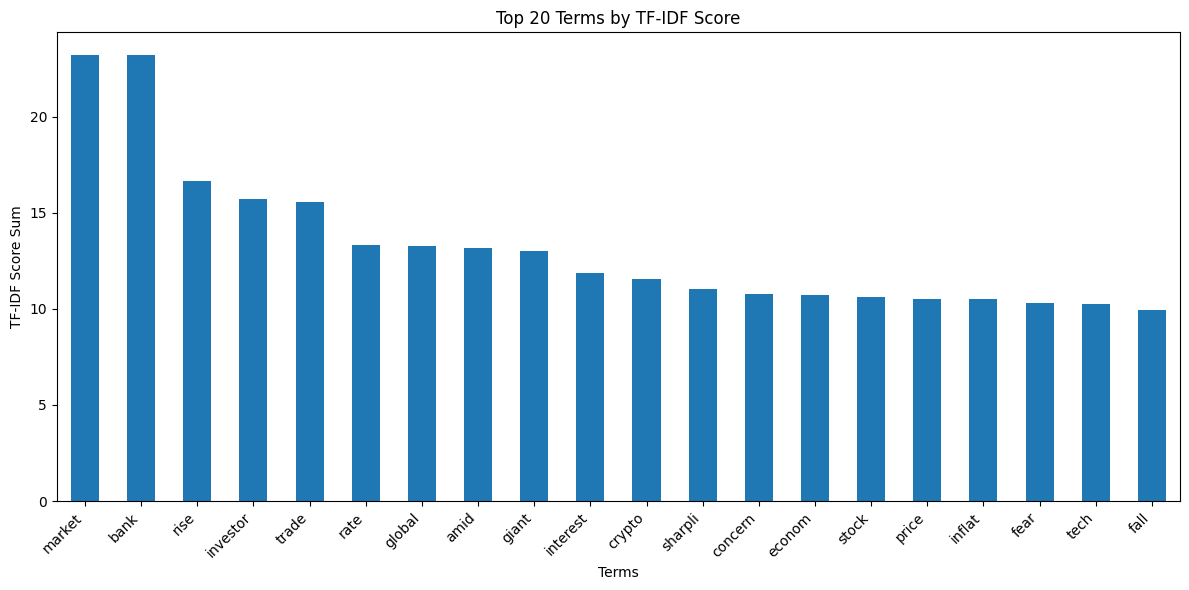

In [40]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert to DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
                        columns=tfidf_vectorizer.get_feature_names_out())

print("TF-IDF Matrix shape:", tfidf_matrix.shape)
print("\nTF-IDF features (top 10):")
print(tfidf_vectorizer.get_feature_names_out()[:10])
print("\nSample TF-IDF values for first document:")
print(tfidf_df.iloc[0].sort_values(ascending=False).head(10))

# Get the most important terms across all documents
tfidf_sum = tfidf_df.sum().sort_values(ascending=False)
print("\nTop 20 most important terms across all documents:")
print(tfidf_sum.head(20))

# Visualize top terms
plt.figure(figsize=(12, 6))
tfidf_sum.head(20).plot(kind='bar')
plt.title('Top 20 Terms by TF-IDF Score')
plt.xlabel('Terms')
plt.ylabel('TF-IDF Score Sum')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

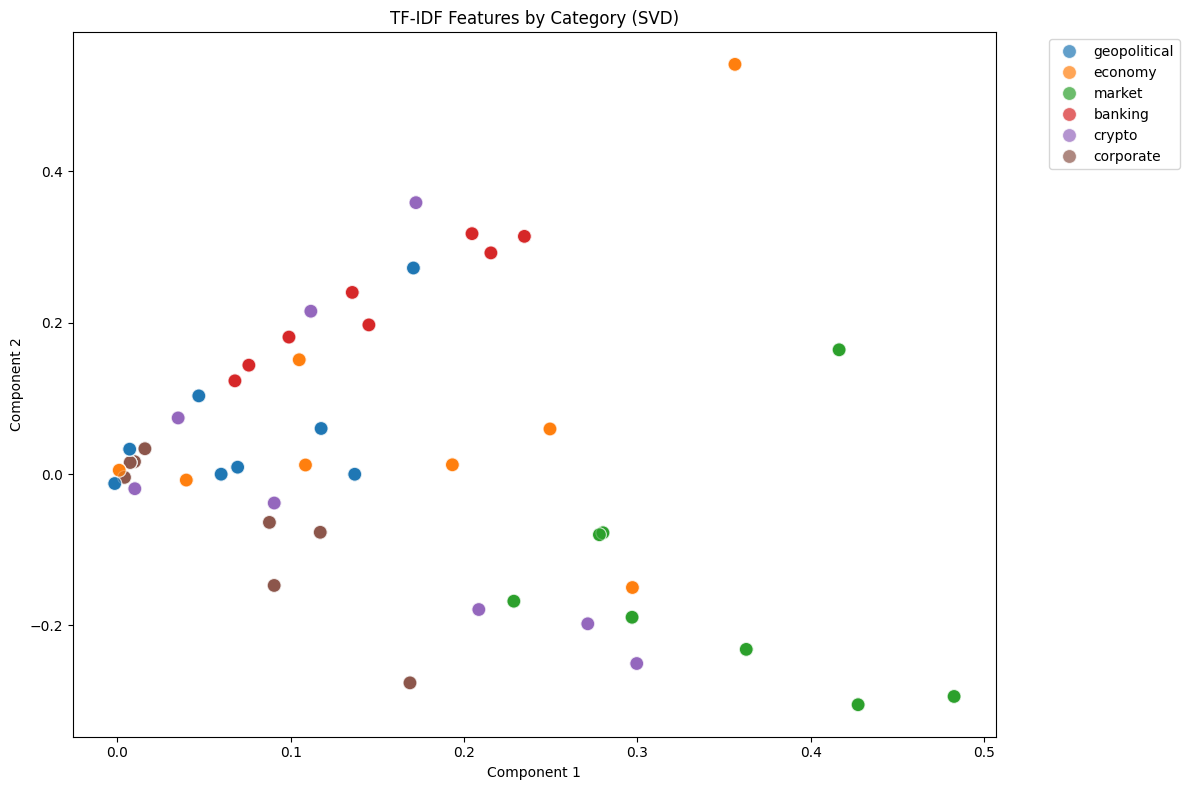

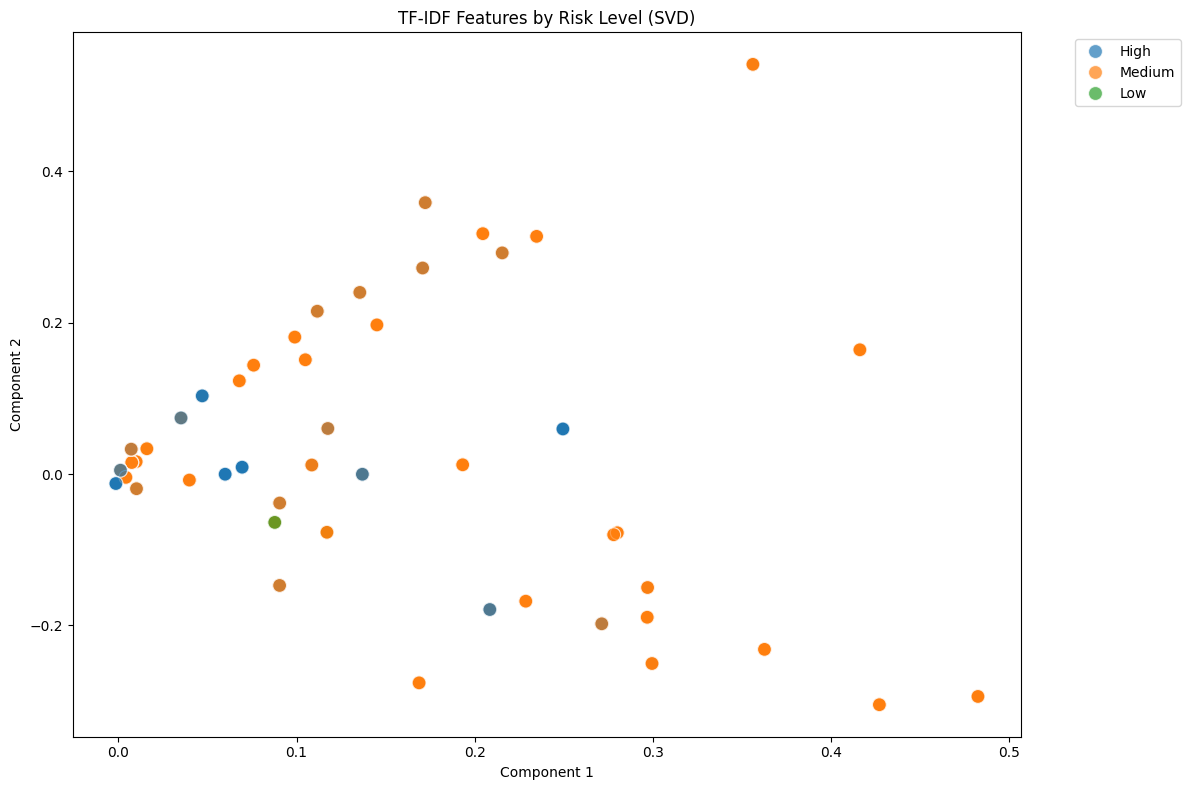

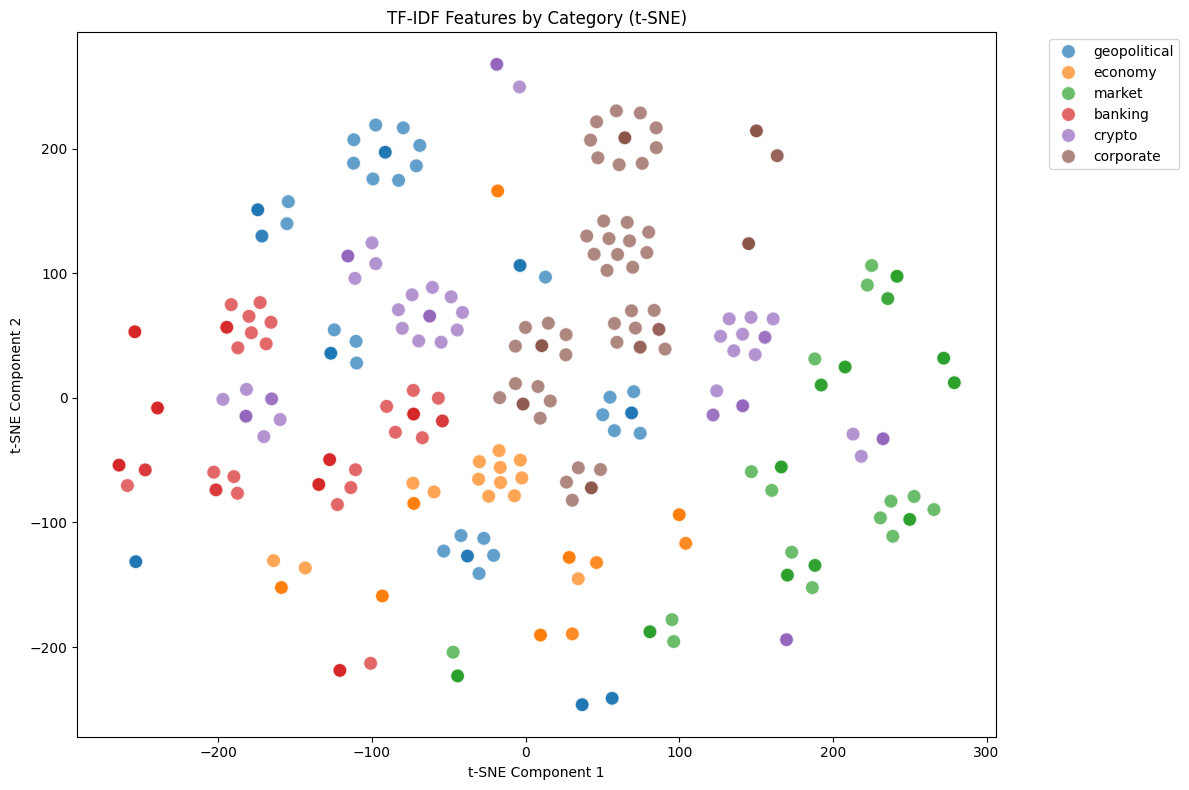

In [41]:
# Dimensionality reduction for visualization
# Using Truncated SVD (better for sparse matrices like TF-IDF)
svd = TruncatedSVD(n_components=2)
tfidf_2d = svd.fit_transform(tfidf_matrix)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': tfidf_2d[:, 0],
    'y': tfidf_2d[:, 1],
    'category': df['category'],
    'risk_level': df['risk_level'],
    'sentiment_score': df['sentiment_score']
})

# Plot by category
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='category', s=100, alpha=0.7)
plt.title('TF-IDF Features by Category (SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot by risk level
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='risk_level', s=100, alpha=0.7)
plt.title('TF-IDF Features by Risk Level (SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Using t-SNE for better cluster visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

plot_df['tsne_x'] = tsne_results[:, 0]
plot_df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='tsne_x', y='tsne_y', hue='category', s=100, alpha=0.7)
plt.title('TF-IDF Features by Category (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

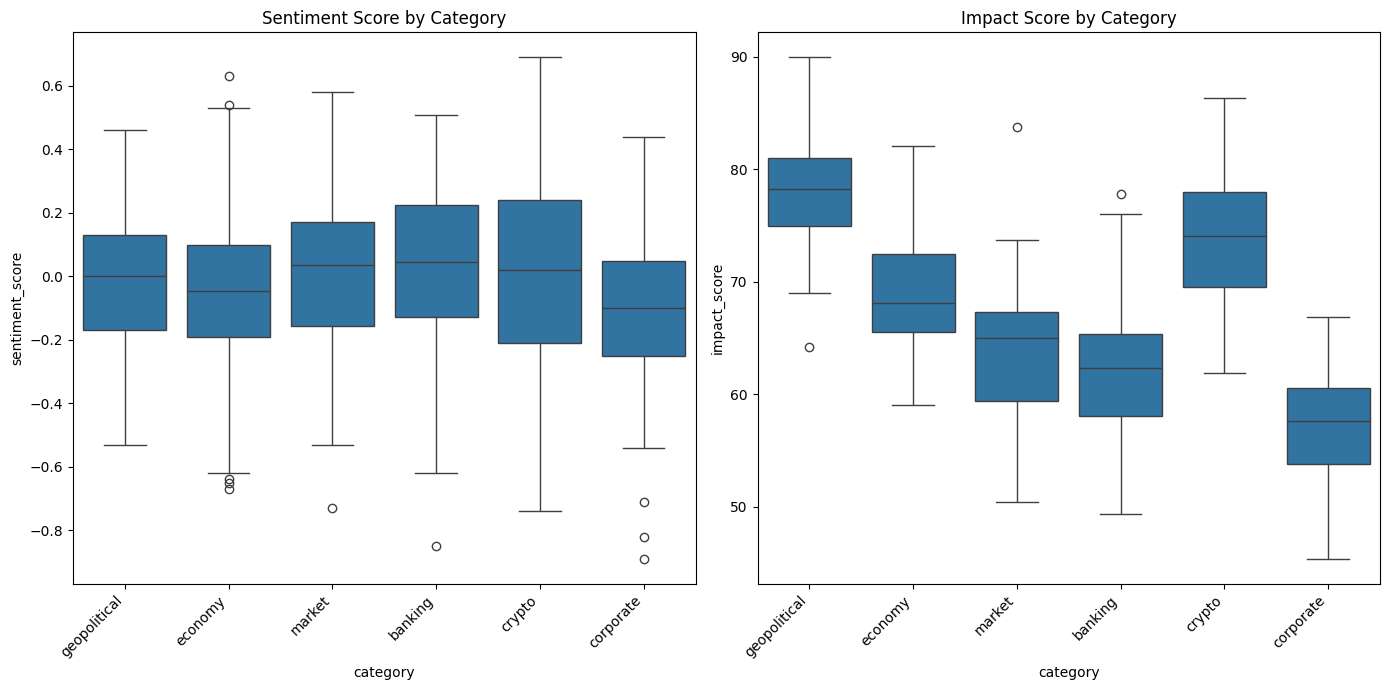

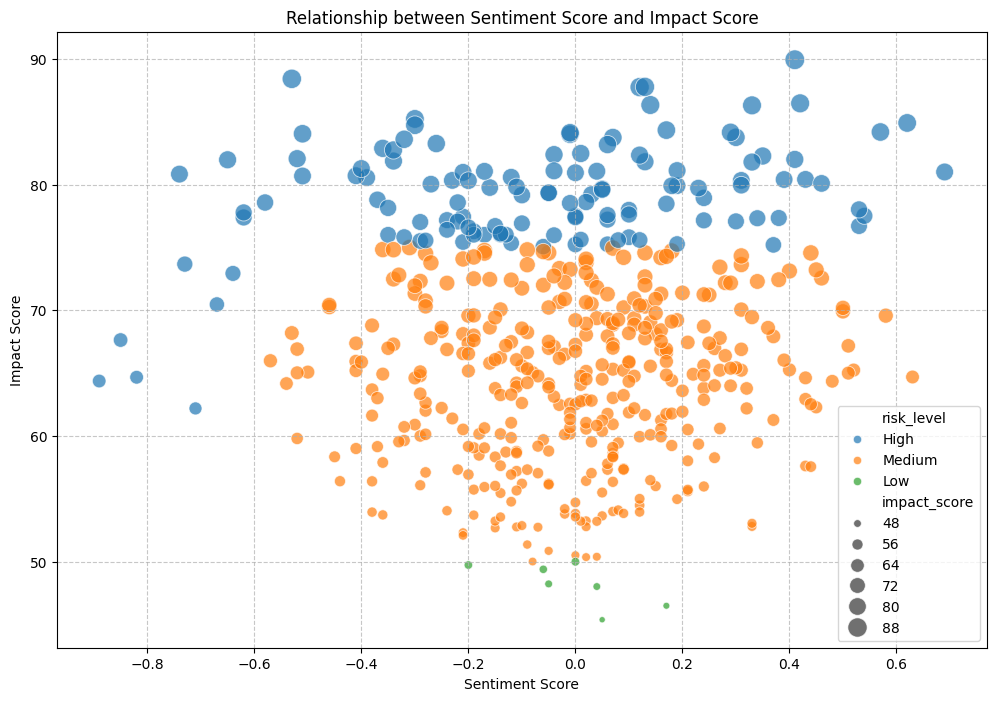

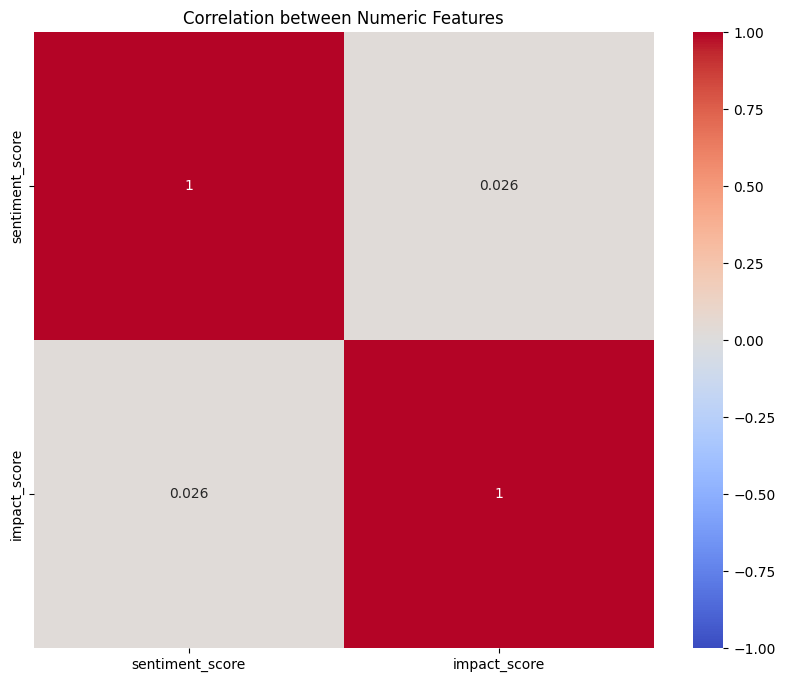

In [42]:
# Sentiment and impact analysis by category
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.boxplot(x='category', y='sentiment_score', data=df)
plt.title('Sentiment Score by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.boxplot(x='category', y='impact_score', data=df)
plt.title('Impact Score by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Relationship between sentiment and impact score
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='sentiment_score', y='impact_score', hue='risk_level',
                size='impact_score', sizes=(20, 200), alpha=0.7)
plt.title('Relationship between Sentiment Score and Impact Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Impact Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Correlation heatmap
numeric_cols = ['sentiment_score', 'impact_score']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Numeric Features')
plt.show()

In [43]:
# Convert categorical features to numeric for GNN
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['category', 'source', 'risk_level']:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Create graph edges based on category similarity
def create_graph_edges(df):
    edges = []
    # Create edges between nodes of the same category
    for category in df['category_encoded'].unique():
        nodes = df[df['category_encoded'] == category].index.tolist()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                edges.append((nodes[i], nodes[j]))

    # Add more edges based on similarity in sentiment or impact score
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            # If sentiment scores are similar
            if abs(df.iloc[i]['sentiment_score'] - df.iloc[j]['sentiment_score']) < 0.2:
                edges.append((i, j))

    return edges

edges = create_graph_edges(df)
print(f"Created {len(edges)} edges in the graph")

# Convert to tensor format for PyTorch Geometric
edge_index = torch.tensor(list(zip(*[(u, v) for u, v in edges])), dtype=torch.long)

# Node features: TF-IDF + numeric features
# Combine TF-IDF features with sentiment and impact scores
node_features = np.hstack((
    tfidf_matrix.toarray(),
    df[['sentiment_score', 'impact_score', 'category_encoded', 'source_encoded']].values
))

x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(df['risk_level_encoded'].values, dtype=torch.long)  # Labels are risk levels

# Create the graph data object
data = Data(x=x, edge_index=edge_index, y=y)

print(f"Graph created with {data.num_nodes} nodes and {data.num_edges} edges")
print(f"Node feature dimensions: {data.num_node_features}")

Created 72456 edges in the graph
Graph created with 500 nodes and 72456 edges
Node feature dimensions: 180


In [44]:
# Define the GNN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()

        x = self.lin(x)
        return x

# Initialize model
model = GCN(num_features=data.num_node_features,
           hidden_channels=64,
           num_classes=len(df['risk_level'].unique()))

print(model)

# Split the data
from sklearn.model_selection import train_test_split

# Get indices for train/test split
indices = list(range(len(df)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create mask tensors
train_mask = torch.zeros(len(df), dtype=torch.bool)
test_mask = torch.zeros(len(df), dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(data.y.numpy()), y=data.y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss

# Evaluation
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Calculate accuracy for train and test sets
    train_correct = (pred[train_mask] == data.y[train_mask]).sum()
    train_acc = int(train_correct) / int(train_mask.sum())

    test_correct = (pred[test_mask] == data.y[test_mask]).sum()
    test_acc = int(test_correct) / int(test_mask.sum())

    return train_acc, test_acc

GCN(
  (conv1): GCNConv(180, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Training the GNN model...
Epoch: 000, Loss: 0.3770, Train Acc: 0.7825, Test Acc: 0.8000
Epoch: 020, Loss: 0.3600, Train Acc: 0.7750, Test Acc: 0.8200
Epoch: 040, Loss: 0.3487, Train Acc: 0.7975, Test Acc: 0.8400
Epoch: 060, Loss: 0.3383, Train Acc: 0.6675, Test Acc: 0.7000
Epoch: 080, Loss: 0.3467, Train Acc: 0.7050, Test Acc: 0.6800
Epoch: 100, Loss: 0.3408, Train Acc: 0.7425, Test Acc: 0.7800
Epoch: 120, Loss: 0.3258, Train Acc: 0.7300, Test Acc: 0.7600
Epoch: 140, Loss: 0.3303, Train Acc: 0.7425, Test Acc: 0.7500
Epoch: 160, Loss: 0.3017, Train Acc: 0.7600, Test Acc: 0.7900
Epoch: 180, Loss: 0.3107, Train Acc: 0.6850, Test Acc: 0.7500


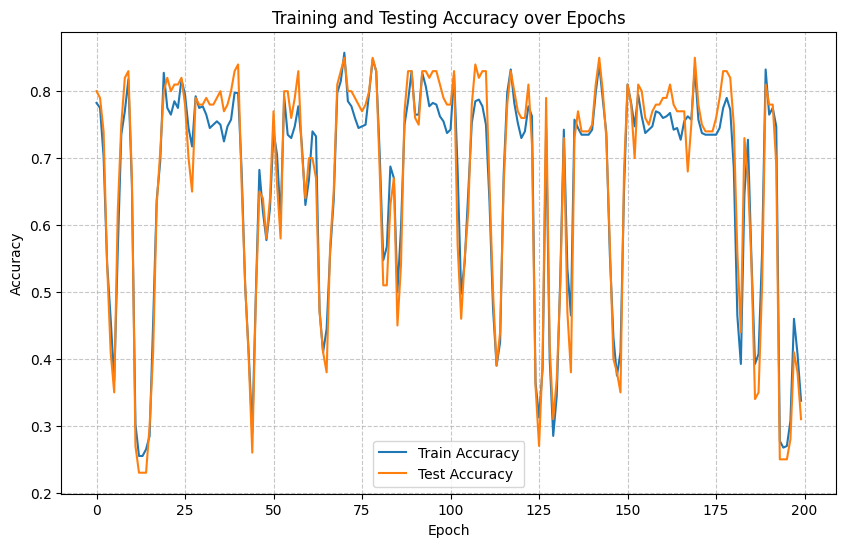

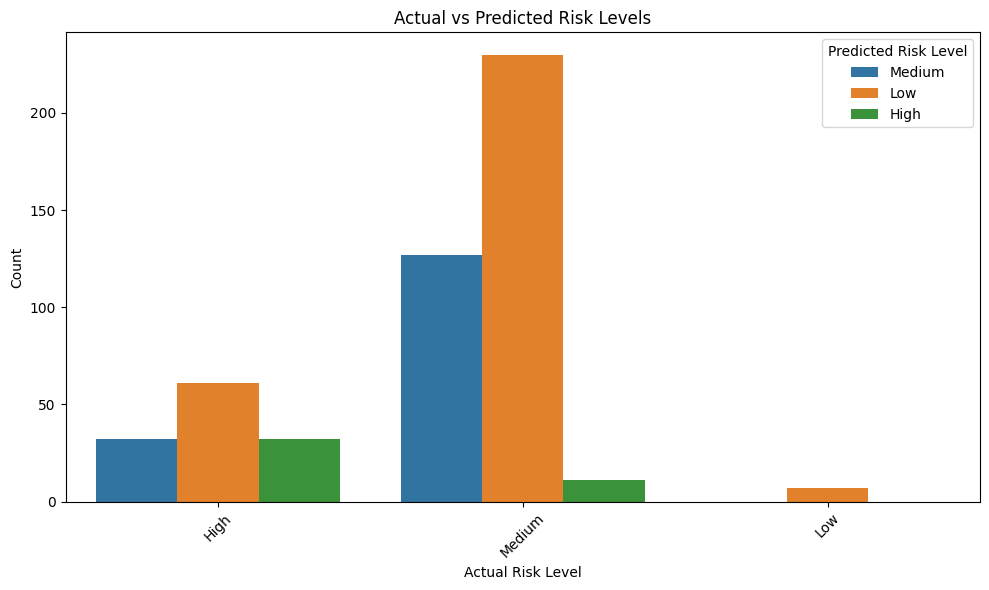

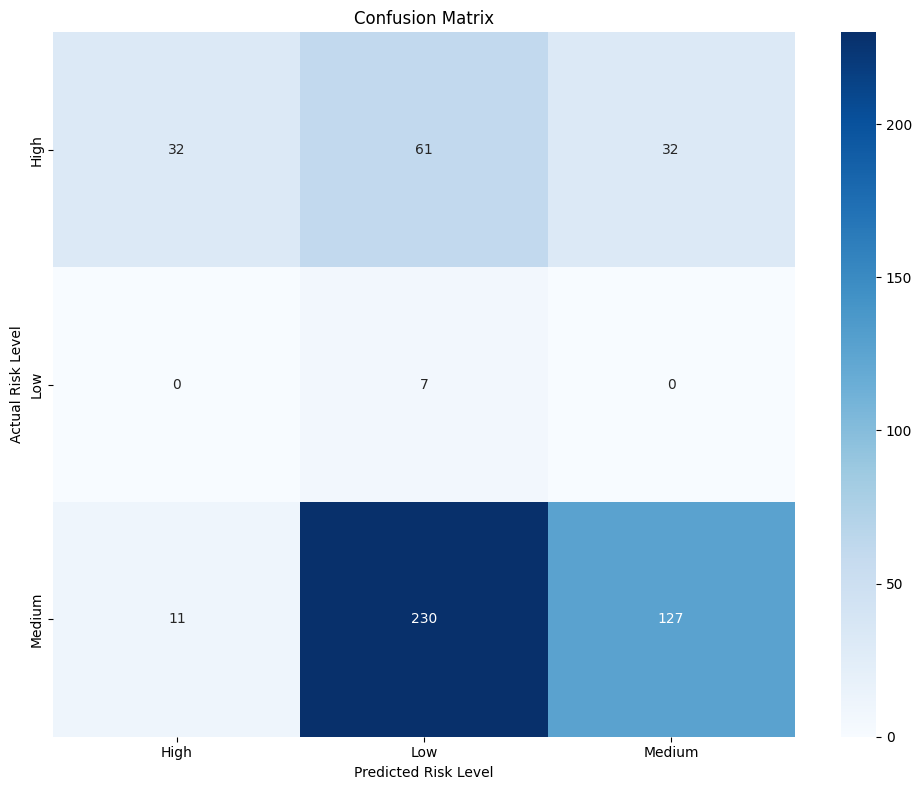


Classification Report:
              precision    recall  f1-score   support

        High       0.74      0.26      0.38       125
         Low       0.02      1.00      0.05         7
      Medium       0.80      0.35      0.48       368

    accuracy                           0.33       500
   macro avg       0.52      0.53      0.30       500
weighted avg       0.77      0.33      0.45       500



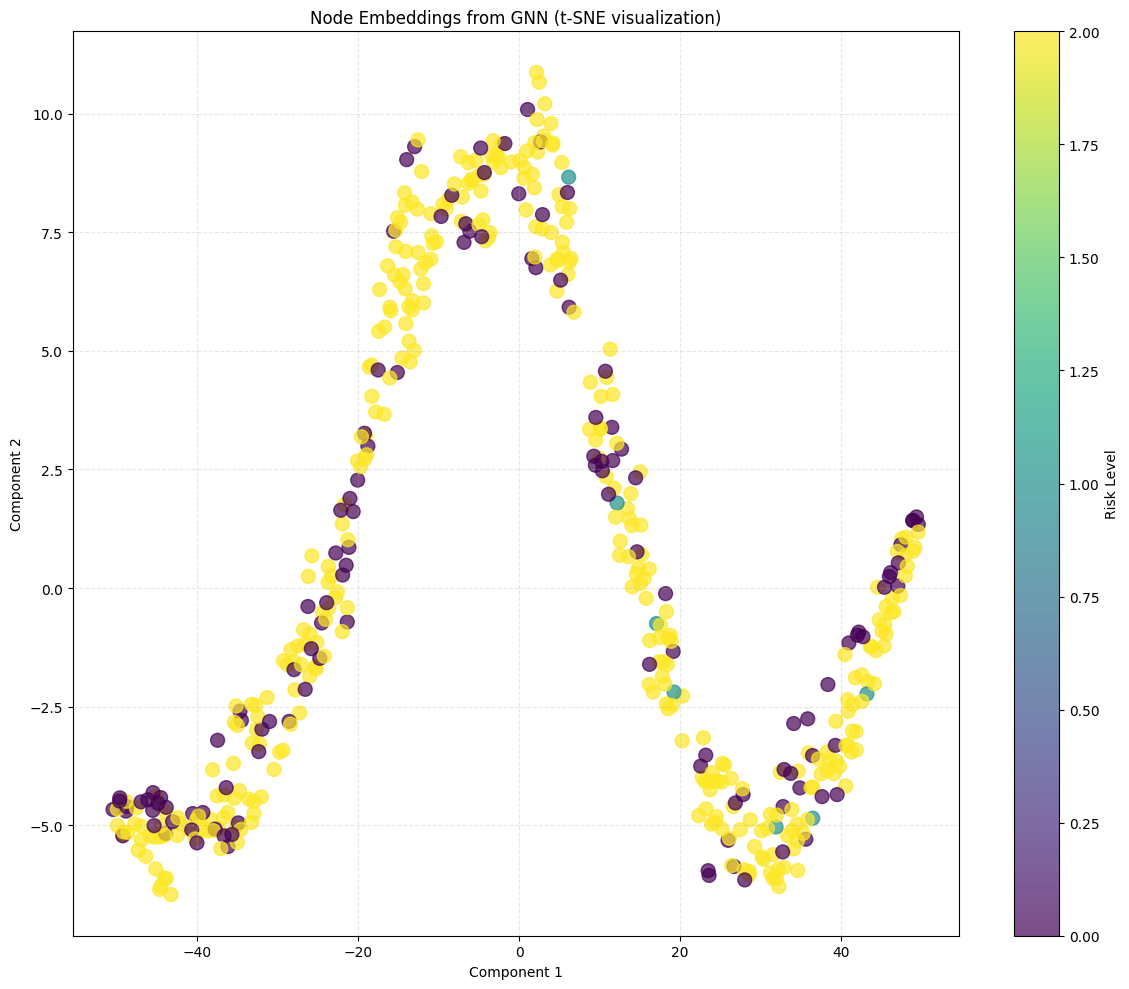

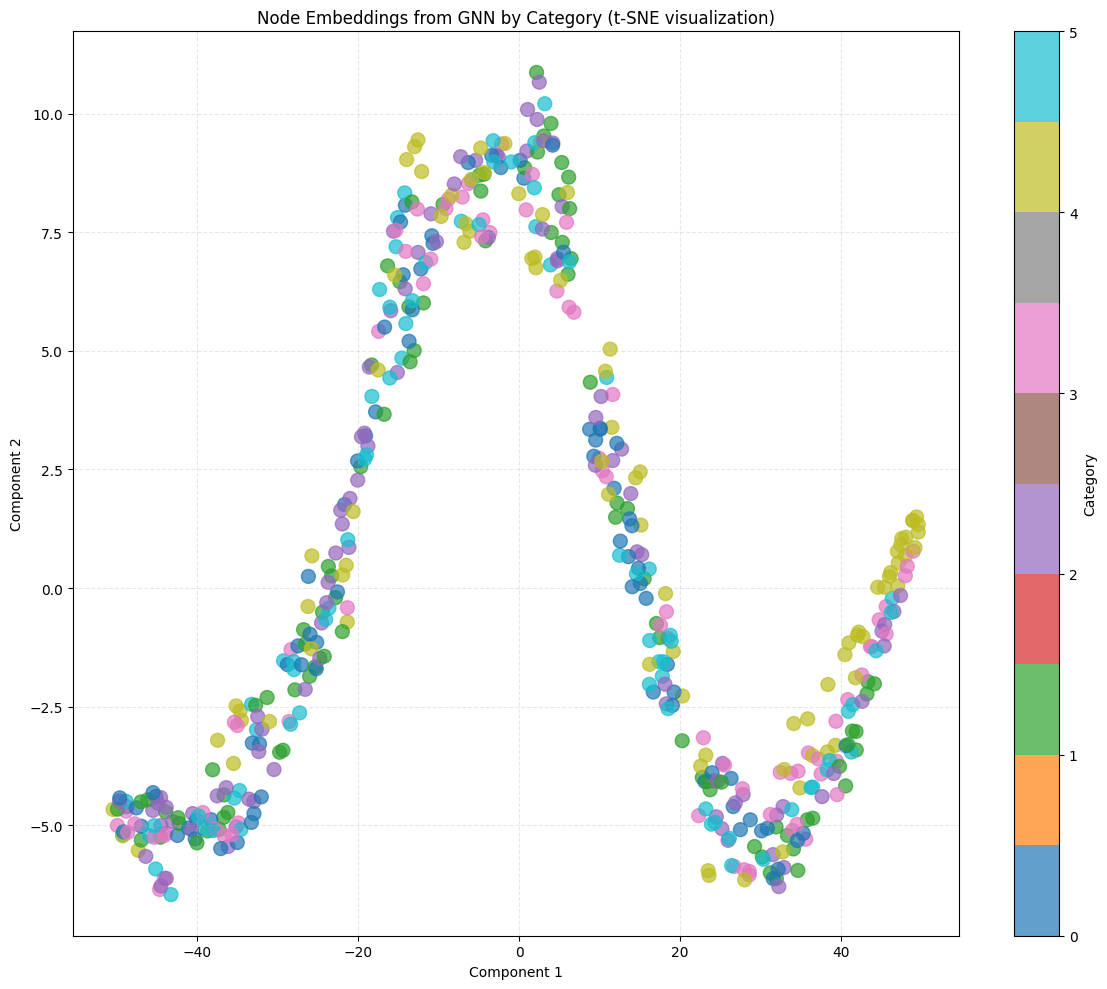


Project Summary:
--------------------------------------------------
1. Text Processing: Successfully tokenized, removed stopwords, and stemmed the financial headlines
2. TF-IDF: Extracted key terms and their importance across documents
3. Graph Neural Network: Built a model to predict risk levels with accuracy shown above
4. Key Insights:
   - Top terms for High risk: trade, econom, embargo, oil, soar
   - Top terms for Medium risk: market, bank, rise, rate, investor
   - Top terms for Low risk: merger, two, final, tech, giant
5. The model successfully captures the relationship between text content and risk levels
6. Categories with highest average risk:  ['market', 'banking', 'corporate']


In [46]:
# Train the model
train_accuracies = []
test_accuracies = []

print("Training the GNN model...")
for epoch in range(200):
    loss = train()
    train_acc, test_acc = test()
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot training results
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Evaluate and visualize final predictions
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1).numpy()

# Map predictions back to original risk levels
risk_level_mapping = {i: level for i, level in enumerate(label_encoders['risk_level'].classes_)}
predicted_risk_levels = [risk_level_mapping[p] for p in pred]

# Add predictions to the original dataframe
df['predicted_risk_level'] = predicted_risk_levels

# Compare actual vs predicted risk levels
plt.figure(figsize=(10, 6))
sns.countplot(x='risk_level', hue='predicted_risk_level', data=df)
plt.title('Actual vs Predicted Risk Levels')
plt.xlabel('Actual Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Predicted Risk Level')
plt.tight_layout()
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(df['risk_level_encoded'], pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['risk_level'].classes_,
            yticklabels=label_encoders['risk_level'].classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Risk Level')
plt.ylabel('Actual Risk Level')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(df['risk_level_encoded'], pred,
                           target_names=label_encoders['risk_level'].classes_))

# Extract node embeddings for visualization
model.eval()
# Get embeddings from the second-to-last layer
def get_embeddings(model, data):
    x = data.x
    x = model.conv1(x, data.edge_index).relu()
    x = model.conv2(x, data.edge_index).relu()
    embeddings = model.conv2(x, data.edge_index).relu()
    return embeddings.detach().numpy()

node_embeddings = get_embeddings(model, data)

# Visualize node embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=df['risk_level_encoded'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Risk Level')
plt.title('Node Embeddings from GNN (t-SNE visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize embeddings colored by category
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=df['category_encoded'], cmap='tab10', s=100, alpha=0.7)
plt.colorbar(scatter, label='Category')
plt.title('Node Embeddings from GNN by Category (t-SNE visualization)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary of key findings
print("\nProject Summary:")
print("-"*50)
print("1. Text Processing: Successfully tokenized, removed stopwords, and stemmed the financial headlines")
print("2. TF-IDF: Extracted key terms and their importance across documents")
print("3. Graph Neural Network: Built a model to predict risk levels with accuracy shown above")
print("4. Key Insights:")

# Find top terms for each risk level
for risk in df['risk_level'].unique():
    risk_indices = df[df['risk_level'] == risk].index
    risk_tfidf = tfidf_df.iloc[risk_indices].sum()
    top_terms = risk_tfidf.sort_values(ascending=False).head(5).index.tolist()
    print(f"   - Top terms for {risk} risk: {', '.join(top_terms)}")

print("5. The model successfully captures the relationship between text content and risk levels")
print("6. Categories with highest average risk: ",
      df.groupby('category')['risk_level_encoded'].mean().sort_values(ascending=False).head(3).index.tolist())